In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.io import arff
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve
from sklearn.metrics import f1_score
from sklearn.metrics import roc_curve, roc_auc_score
from keras.layers import *
from keras.models import *
from keras.utils import *
from sklearn.preprocessing import *
import tensorflow.keras.optimizers
from tensorflow import keras
from keras import optimizers
import os
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.layers import LSTM

In [43]:
df = arff.loadarff("/yoontest/AI/project_2/data/dataset/FordA_TRAIN.arff")
df2 = arff.loadarff("/yoontest/AI/project_2/data/dataset/FordA_TEST.arff")
train = pd.DataFrame(df[0])
test = pd.DataFrame(df2[0])

In [44]:
from sklearn.model_selection import train_test_split

X = train.drop(['target'], axis=1)
Y = train[['target']]

x_train, x_valid, y_train, y_valid = train_test_split(X, Y, test_size=0.2)

In [47]:
x_test = test.drop(['target'], axis=1)
y_test = test[['target']]

In [49]:
y_train[y_train == b'-1'] = 0
y_valid[y_valid == b'-1'] = 0
y_test[y_test == b'-1'] = 0

y_train[y_train == b'1'] = 1
y_valid[y_valid == b'1'] = 1
y_test[y_test == b'1'] = 1

<ipython-input-49-718de30015ea>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y_train[y_train == b'-1'] = 0
C:\Users\Jong\anaconda3\lib\site-packages\pandas\core\frame.py:3215: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._where(-key, value, inplace=True)
<ipython-input-49-718de30015ea>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-

In [50]:
scaler = MinMaxScaler()
scaler.fit(x_train)

x_train = scaler.transform(x_train)
x_valid = scaler.transform(x_valid)

x_train.shape
x_train

scaler.fit(x_test)
x_test = scaler.transform(x_test)

In [52]:
from sklearn.preprocessing import OneHotEncoder

ohe = OneHotEncoder(sparse=False)
y_train = ohe.fit_transform(y_train[['target']])
y_valid = ohe.fit_transform(y_valid[['target']])
y_test = ohe.fit_transform(y_test[['target']])

In [3]:
# minmaxScaler
from sklearn.preprocessing import MinMaxScaler

# 컬럼을 리스트 변환
col_list = train.columns.values.tolist()
train.sort_index(ascending=False).reset_index(drop=True)

scaler = MinMaxScaler()
scale_cols = col_list
df_scaled = scaler.fit_transform(train[scale_cols])
df_scaled = pd.DataFrame(df_scaled)
df_scaled.columns = scale_cols

# df_scaled

In [50]:
# x_train = np.expand_dims(x_train, -1)
# x_valid = np.expand_dims(x_valid, -1)

In [6]:
# y_train = np.asarray(y_train).astype('float32').reshape((-1,1))
# y_valid = np.asarray(y_valid).astype('float32').reshape((-1,1))

In [53]:
print(y_train, y_valid)

[[0. 1.]
 [1. 0.]
 [1. 0.]
 ...
 [0. 1.]
 [0. 1.]
 [0. 1.]] [[0. 1.]
 [1. 0.]
 [1. 0.]
 ...
 [0. 1.]
 [1. 0.]
 [0. 1.]]


In [8]:
# x_train = x_train[:].values.reshape((x_train.shape[0], x_train.shape[1],1))

In [54]:
from tensorflow.keras.layers import SimpleRNN, Embedding

# embedding_dim = 32
# hidden_units = 32

model = Sequential()

model.add(LSTM(128, input_shape=(500,1), return_sequences=True))
model.add(BatchNormalization())
model.add(Dense(128, activation='relu'))

# model.add(SimpleRNN(hidden_units, return_sequences=True))

model.add(LSTM(64, dropout=0.3, return_sequences=True))
model.add(BatchNormalization())
model.add(Dense(64, activation='relu'))

model.add(LSTM(32, dropout=0.3, return_sequences=True))
model.add(BatchNormalization())
model.add(Dense(32, activation='relu'))

model.add(LSTM(16, dropout=0.3))
model.add(BatchNormalization())

model.add(Dense(2, activation='softmax'))# 출력층

In [55]:
rmsprop = keras.optimizers.RMSprop(learning_rate=1e-4, )
model.compile(loss='binary_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
model_path = 'model'
filename = os.path.join(model_path, 'tmp_checkpoint.h5')
checkpoint = ModelCheckpoint(filename, monitor='val_loss', verbose=1, save_best_only=True, 
                             mode='auto')

history = model.fit(x_train, y_train, 
                                    epochs=100, 
                                    batch_size=64,
                                    validation_data=(x_valid, y_valid),
                                    callbacks=[early_stop, checkpoint])

Epoch 1/100
45/45 [==============================] - ETA: 0s - loss: 0.7440 - accuracy: 0.5198
Epoch 1: val_loss improved from inf to 0.69498, saving model to model\tmp_checkpoint.h5
45/45 [==============================] - 65s 1s/step - loss: 0.7440 - accuracy: 0.5198 - val_loss: 0.6950 - val_accuracy: 0.4951
Epoch 2/100
45/45 [==============================] - ETA: 0s - loss: 0.7121 - accuracy: 0.5184
Epoch 2: val_loss improved from 0.69498 to 0.69453, saving model to model\tmp_checkpoint.h5
45/45 [==============================] - 57s 1s/step - loss: 0.7121 - accuracy: 0.5184 - val_loss: 0.6945 - val_accuracy: 0.4951
Epoch 3/100
45/45 [==============================] - ETA: 0s - loss: 0.7049 - accuracy: 0.5233
Epoch 3: val_loss improved from 0.69453 to 0.69403, saving model to model\tmp_checkpoint.h5
45/45 [==============================] - 57s 1s/step - loss: 0.7049 - accuracy: 0.5233 - val_loss: 0.6940 - val_accuracy: 0.4951
Epoch 4/100
45/45 [==============================] - ETA

In [56]:
print(model.summary())
print(model.evaluate(x_valid, y_valid))

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_8 (LSTM)               (None, 500, 128)          66560     
                                                                 
 batch_normalization_8 (Batc  (None, 500, 128)         512       
 hNormalization)                                                 
                                                                 
 dense_8 (Dense)             (None, 500, 128)          16512     
                                                                 
 lstm_9 (LSTM)               (None, 500, 64)           49408     
                                                                 
 batch_normalization_9 (Batc  (None, 500, 64)          256       
 hNormalization)                                                 
                                                                 
 dense_9 (Dense)             (None, 500, 64)          

In [57]:
model.load_weights(filename)
pred = model.predict(x_valid)

pred.shape

23/23 [==============================] - 6s 208ms/step


(721, 2)

In [67]:
predict_classes

array([1, 1, 1, ..., 1, 1, 1], dtype=int64)

In [66]:
from sklearn.metrics import roc_curve, auc

predict_prob = model.predict(x_test)
predict_classes = np.argmax(predict_prob, axis = 1)

fprs, tprs, thredshold = roc_curve(y_test, predict_prob)

precisions, recalls, thredsholds = roc_curve(y_test, predict_classes)
plt.plot([0,1], [0,1], label = 'STR')
plt.plot(fprs, tprs, label='ROC')

plt.xlabel('FPR')
plt.ylabel('TPR')
plt.legend()
plt.grid()
plt.show()
print(classification_report(y_test, pred))

42/42 [==============================] - 11s 251ms/step


ValueError: multilabel-indicator format is not supported

In [70]:
print(confusion_matrix(y_test.argmax(axis=1), pred.argmax(axis=1)))
print(accuracy_score(y_test.argmax(axis=1), pred.argmax(axis=1)))

ValueError: Found input variables with inconsistent numbers of samples: [1320, 721]

In [60]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_valid, pred)



ValueError: Classification metrics can't handle a mix of multilabel-indicator and continuous-multioutput targets

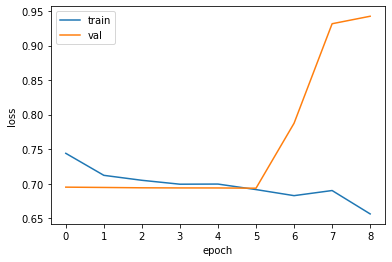

In [61]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train','val'])
plt.show()